### Notebook to perform the unsupervised deep image prior generation of experimental nanoparticles reconstruction from degraded acquisition conditions

*The data set consists of 2D projections from experimental nanoparticles (-60°:2°:+60°). Two realistic additional degraded scenarios are also compared.*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

Describe the scenario more in details

In [1]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import torch
from pathlib import Path

plt.gray()

dtype = torch.cuda.FloatTensor
DEVICE = 'cuda'

<Figure size 640x480 with 0 Axes>

#### Load the experimental nanoparticles  sinogram to reconstruct with deep image prior

The projections are first reshaped to 512x512 size.
No reference sinograms and reconstructions are available in this acquisition scenario.

describe the data, shape, scenarios choice, parameters

In [ ]:
IDX = 159 
projections = imread('../../Data/Experimental/haadf_experimental_data.tif')
proj = projections[:,IDX,:]
sinogram = torch.from_numpy(proj).type(dtype)

THETA = np.arange(27., 151., 2.)
IMG_SIZE = sinogram.shape[1]

# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3
SELECT = {
    1: [sinogram, THETA],
    2: [sinogram[::5,:], THETA[::5]],
    3: [sinogram[15:-15,:], THETA[15:-15]],
}

degraded_sino = SELECT[ACQUISITION_CASE][0]
degraded_THETA = SELECT[ACQUISITION_CASE][1]

radon_op = Radon2D(angle=np.deg2rad(THETA), size=IMG_SIZE)
sirt_reco = radon_op.backward_sirt_ts(sinogram)

Text(0.5, 1.0, 'Degraded sinogram (missing projections)')

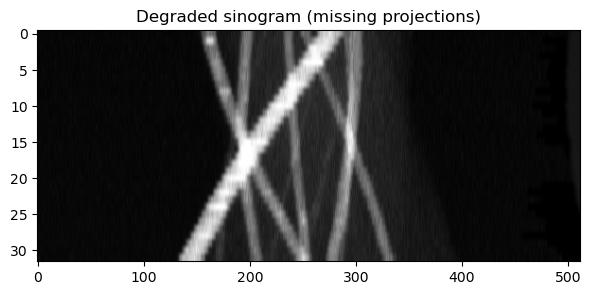

In [3]:
plt.figure(figsize = (7,3))
plt.imshow(simplify(degraded_sino), aspect='auto')
plt.title('Degraded sinogram (missing projections)')

#### Networks and training parameters

- INPUT_DEPTH : Shape of the input noise
- STD_INP_NOISE : value of the input noise
- NOISE_REG : regularization value on the input noise after each iteration

describe a bit mroe the method, which parameters are used, changable, usable, fixed, etc

In [7]:
NUM_ITER = 2000
LR = 0.01
INPUT_DEPTH = 32
STD_INP_NOISE = 1./10. 
NOISE_REG = 1./30.

In [8]:
n_scale = 4
ud_filters=[16,32,64,128]
skip_filters=[4,8,16,32]
network = model_unet(input_shape=INPUT_DEPTH,
                  output_shape=1,
                  down_filters=ud_filters,
                  up_filters=ud_filters,
                  skip_filters=skip_filters,
                  down_kernels=[3]*n_scale,
                  up_kernels=[3]*n_scale,
                  skip_kernels=[1]*n_scale,
                  up_mode='bilinear',
                  down_mode='stride',
                  pad_mode='zeros',
).to('cuda').type(dtype)

  0%|          | 0/2000 [00:00<?, ?it/s]/nobackup/sb272614/Environments/env_tomo/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 512])) that is different to the input size (torch.Size([1, 1, 32, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


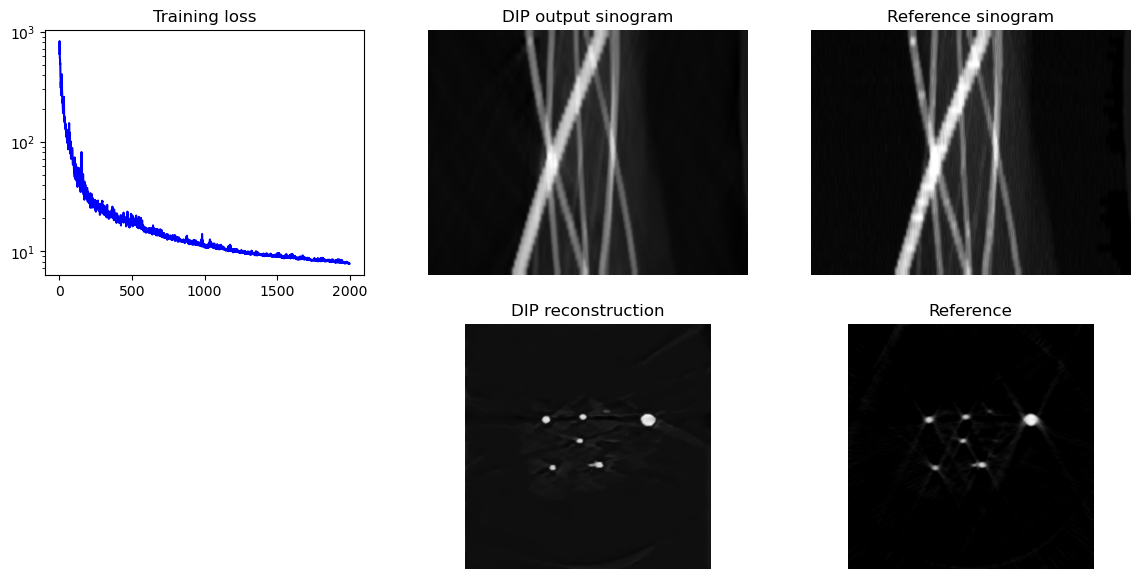

100%|██████████| 2000/2000 [00:59<00:00, 33.55it/s]


In [9]:
output = dip_reconstruction(NUM_ITER, LR, IMG_SIZE, STD_INP_NOISE, NOISE_REG,
                            np.flip(degraded_THETA), INPUT_DEPTH,
                            degraded_sino, sirt_reco, network, DISPLAY=True,
                            tv_weight=0.0, tv_order=1)

best_loss   = output['best_loss']
best_output = normalize(output['best_output'])
best_i      = output['best_i']
loss_values = output['loss_values']
net_trained = output['net']
best_input  = output['best_input']

#### Save the generated restored image

In [22]:
OUT_PATH = Path("../../Temp_out")
if not OUT_PATH.is_dir():
    OUT_PATH.mkdir()

imsave(f'{OUT_PATH}/out_exp_dip_{ACQUISITION_CASE}.tif', simplify(best_output))

/tmp/ipykernel_2909247/1346544440.py:5: UserWarning: ../../Temp_out/out_exp_dip_3.tif is a low contrast image
  imsave(f'{OUT_PATH}/out_exp_dip_{ACQUISITION_CASE}.tif', simplify(best_output))
